# INTRODUCTION



Employee retention is critical for organizations, impacting company performance and the workplace culture. This report will explore the factors influencing an employee's decision to leave a company and building a model that predicts whether an employee leaves or not based on those factors. 

A particular focus has been placed on how demographic factors such as age, gender, and payment tier affect turnover rates.


**Objective:**

This study aims to investigate the following question:
### <center> Is an employee going to leave a company based on age, gender, and salary? </center>



This research will be conducted with reference to existing literature, including "Employee Retention Practices in Hospitality Industry in Nepal: Investigating the Moderating Effect of Management Hierarchy, Age Group and Gender" by Sthapit and Shrestha in 2018 which provide insights into the covariates of interest. By aligning our analysis with these findings, we aim to contribute to the broader understanding of employee turnover and inform organizational practices.

**Background information:**

This study has highlighted that young employees may be more prone to leaving their jobs compared to older employees (Ng et al., 2010). Additionally, the gender dynamics of employee turnover rates are differently distributed between male and female employees. "Women might have different turnover rates compared to men, influenced by organizational support and workplace environment (Hom et al., 2017).

The role of salary as a predictor of employee retention has also been a subject of extensive research. The relationship is complex and may vary depending on other factors such as job satisfaction and career advancement opporunities (Trevor et al., 1997)

## The Data Set

### Employee Retention data set: 
**Source:** https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset?resource=download

**Summary:**
- Number of observations: 4654
- Number of features: 9

**Features:**
- `education`: the degree which each employee obtain.
- `JoiningYear`: year at which the employee join the company.
- `City`: The location or city where each employee is based or works.
- `PaymentTier`: categorization of employees into different salary tiers.
- `Age`: the age of each employee, providing demographic insights.
- `Gender`: gender identity of employees, promoting diversity analysis.
- `EverBenched`: Indicates if an employee has ever been temporarily without assigned work.
- `ExperienceInCurrentDomain`: the number of years of experience employees have in their current field.
- `LeaveOrNot`: whether the employee left the company or not.

**Background:**

The data have been collected from company's HR department in 2018 which provide valuable insights into the workforce while maintaining employees privacy rights.

# METHODS and RESULTS

In [42]:
# We first attach any necessary libraries to conduct our exploratory data analysis and modelling
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(AER)
library(GGally)
library(modelr)
library(faraway)
library(MASS)
library(caret)
library(glmnet)
library(ggplot2)
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [34]:
# Demonstrate that the dataset can be read into R
employee <- read_csv("https://drive.google.com/uc?export=download&id=1M7kblkESIbEDBM77F9Iipf8JwR7BYJ0s")

head(employee)

Rows: 4653 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Education, City, Gender, EverBenched
dbl (5): JoiningYear, PaymentTier, Age, ExperienceInCurrentDomain, LeaveOrNot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Bachelors,2017,Bangalore,3,34,Male,No,0,0
Bachelors,2013,Pune,1,28,Female,No,3,1
Bachelors,2014,New Delhi,3,38,Female,No,2,0
Masters,2016,Bangalore,3,27,Male,No,5,1
Masters,2017,Pune,3,24,Male,Yes,2,1
Bachelors,2016,Bangalore,3,22,Male,No,0,0


It was first demonstrated that the Employee Retention dataset can be read into R. For easy collaboration and access without having to modify the read function's file path argument, a Google Drive direct output link was generated to read the dataset directly from an online source.


In [36]:
# Clean and wrangle your data into a tidy format
employee_clean <- employee %>%  
mutate(LeaveOrNot = as_factor(LeaveOrNot)) %>% 
mutate(Gender = as_factor(Gender)) %>% 
mutate(JoiningYear = 2018 - JoiningYear) %>% 
rename(YearsInCompany = JoiningYear) %>% 
mutate(EverBenched = as_factor(EverBenched)) %>%
mutate(PaymentTier = as_factor(PaymentTier)) 

head(employee_clean)


Education,YearsInCompany,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>
Bachelors,1,Bangalore,3,34,Male,No,0,0
Bachelors,5,Pune,1,28,Female,No,3,1
Bachelors,4,New Delhi,3,38,Female,No,2,0
Masters,2,Bangalore,3,27,Male,No,5,1
Masters,1,Pune,3,24,Male,Yes,2,1
Bachelors,2,Bangalore,3,22,Male,No,0,0


It is observed that the data is in a tidy format, with each column representing a variable and each row representing an observation (in this case, an employee). However, further data cleaning and transformation is necessary to streamline our methods of analysis and modelling. First, the retention (LeaveOrNot), gender (Gender), bench status (EverBenched), and salary level (PaymentTier) variables were transformed from a double to a factor data type to reflect their real-world state. The year joined (JoiningYear) variable was also transformed to a length of service (YearsInCompany) variable by subtracting their joining year from the year of data collection, which is assumed to be 2018.

In [53]:
# Any summary tables that are relevant to your analysis.
sum(is.na(employee_clean))
nrow(employee_clean)

retention_proportions <- employee_clean %>%
  count(LeaveOrNot) %>%
  mutate(retention_proportion = n / sum(n))
retention_proportions

payment_tier_proportions <- employee_clean %>%
  count(LeaveOrNot, PaymentTier) %>%
  group_by(LeaveOrNot) %>%
  mutate(proportion_payment = n / sum(n))
payment_tier_proportions

age_gender_yoe_proportions <- employee_clean %>%
  group_by(LeaveOrNot) %>%
  summarise(
    proportion_male = mean(Gender == "Male"),
    average_age = mean(Age))
age_gender_yoe_proportions


[1] 0

[1] 4653

LeaveOrNot,n,retention_proportion
<fct>,<int>,<dbl>
0,3053,0.6561358
1,1600,0.3438642


LeaveOrNot,PaymentTier,n,proportion_payment
<fct>,<fct>,<int>,<dbl>
0,1,154,0.05044219
0,2,368,0.12053718
0,3,2531,0.82902064
1,1,89,0.05562500
1,2,550,0.34375000
1,3,961,0.60062500


LeaveOrNot,proportion_male,average_age
<fct>,<dbl>,<dbl>
0,0.6754012,29.5719
1,0.4475000,29.0525


Warning message in geom_bar(position = "dodge", bins = 8):
“Ignoring unknown parameters: `bins`”


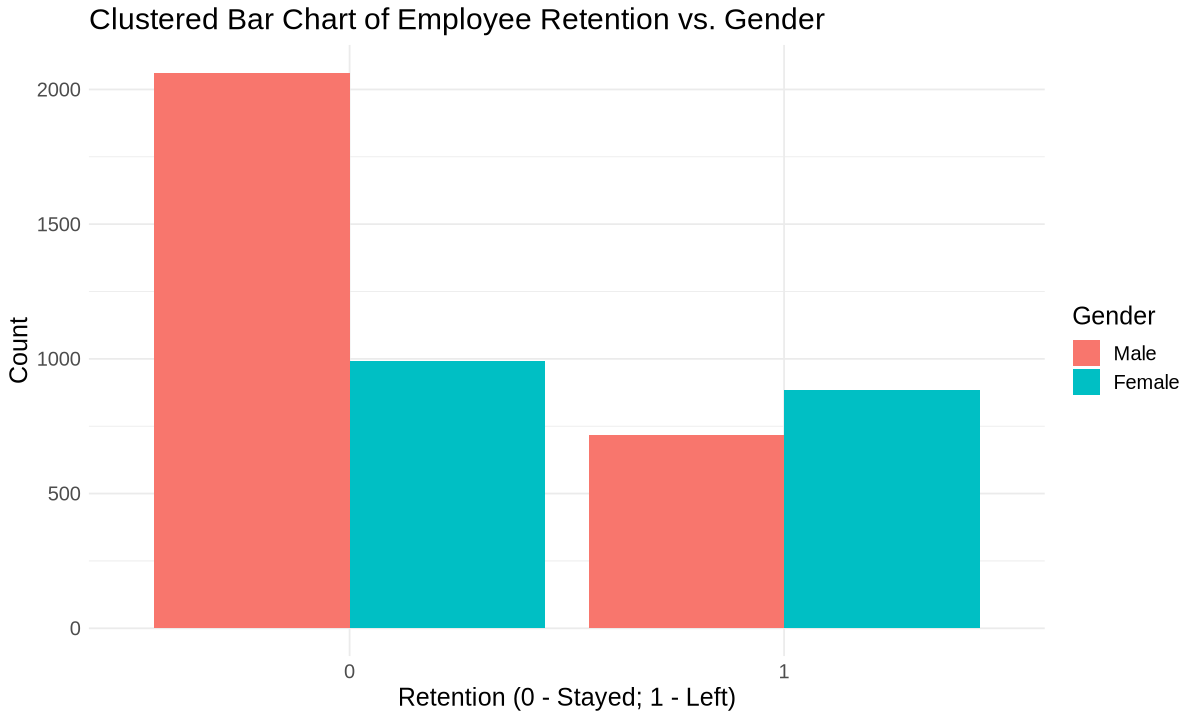

In [63]:
# Plot the relevant raw data, tailoring your plot to address your question.
options(repr.plot.width = 10, repr.plot.height = 6) 

# Clustered Bar Chart of Retention, Filled by Gender
gender_retention_barchart <- 
    employee_clean %>%
    ggplot(aes(LeaveOrNot, 
               fill = Gender)) +
    geom_bar(position = "dodge",
             bins = 8) +
    theme(text = element_text(size = 22)) +
    ggtitle("Clustered Bar Chart of Employee Retention vs. Gender") +
    labs(x = "Retention (0 - Stayed; 1 - Left)", y = "Count", fill = "Gender") +
    theme_minimal() +
    theme(
    text = element_text(size = 15),          
  )
gender_retention_barchart


Warning message in geom_bar(position = "dodge", bins = 8):
“Ignoring unknown parameters: `bins`”


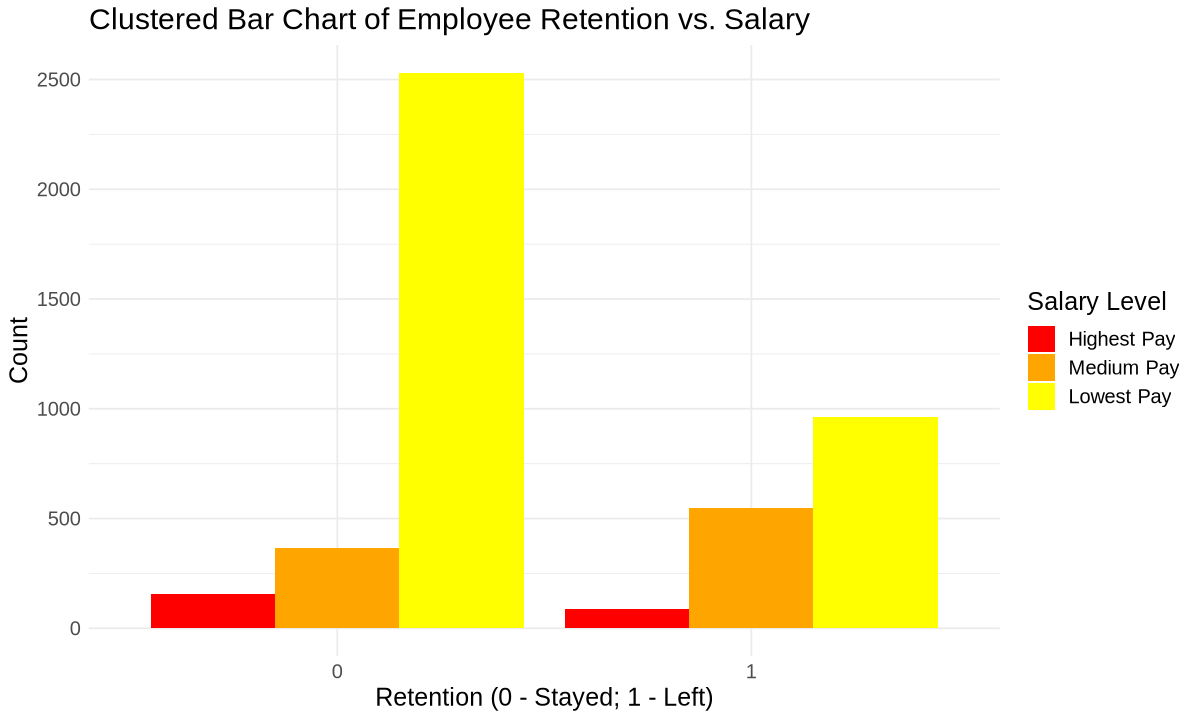

In [64]:
# Clustered Bar Chart of Retention, Filled by Salary
salary_retention_barchart <- 
    employee_clean %>%
    ggplot(aes(LeaveOrNot, 
               fill = PaymentTier)) +
    geom_bar(position = "dodge",
             bins = 8) +
    theme(text = element_text(size = 22)) +
    ggtitle("Clustered Bar Chart of Employee Retention vs. Salary") +
    scale_fill_manual(values = c("red", "orange", "yellow"), labels = c("Highest Pay", "Medium Pay", "Lowest Pay")) +
    labs(x = "Retention (0 - Stayed; 1 - Left)", y = "Count", fill = "Salary Level") +
    theme_minimal() +
    theme(
    text = element_text(size = 15),          
  )
salary_retention_barchart


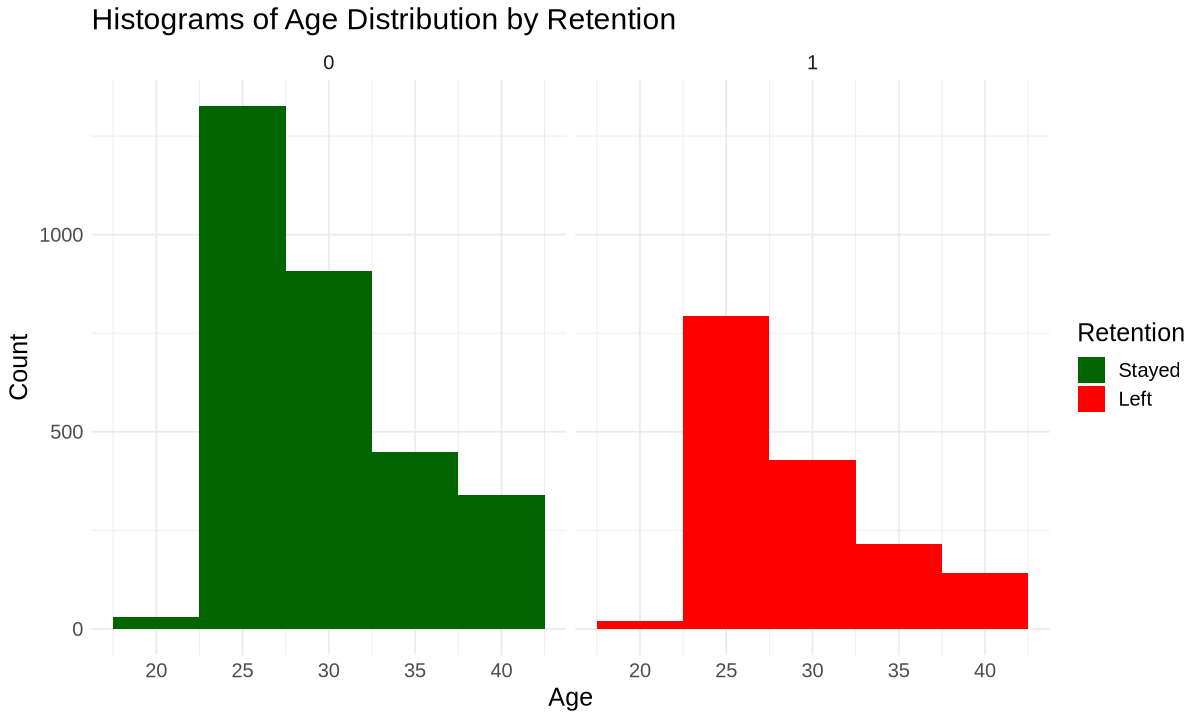

In [65]:
# Side-by-side Histograms of Age Distribution by Retention
age_retention_histogram <- 
    employee_clean %>%
    ggplot(aes(x = Age, fill = as.factor(LeaveOrNot))) +
    geom_histogram(position = "dodge", binwidth = 5) +
    facet_wrap(~LeaveOrNot, scales = "fixed") + 
    scale_fill_manual(values = c("0" = "dark green", "1" = "red"),
                      labels = c("Stayed", "Left")) +
    theme(text = element_text(size = 22)) +
    ggtitle("Histograms of Age Distribution by Retention") +
    labs(x = "Age", y = "Count", fill = "Retention") +
    theme_minimal() +
    theme(
        text = element_text(size = 15)
    )
age_retention_histogram


In [66]:
# Fit initial model with only the intercept
intercept_model <- glm(LeaveOrNot ~ 1, family = binomial, data = employee_clean)
complete_model <- glm(LeaveOrNot ~ ., family = binomial, data = employee_clean)

# Perform forward selection
selected_model <- stepAIC(intercept_model, 
                          scope = list(lower = intercept_model, upper = complete_model), 
                          direction = "forward", 
                          trace = FALSE)

# View the selected model
results <- summary(selected_model)
selected_model
coef(results)


Call:  glm(formula = LeaveOrNot ~ PaymentTier + Gender + YearsInCompany + 
    City + Education + EverBenched + Age + ExperienceInCurrentDomain, 
    family = binomial, data = employee_clean)

Coefficients:
              (Intercept)               PaymentTier2  
                  0.29130                    0.59140  
             PaymentTier3               GenderFemale  
                 -0.18072                    0.89970  
           YearsInCompany              CityNew Delhi  
                 -0.19456                   -0.63423  
                 CityPune           EducationMasters  
                  0.55350                    0.72081  
             EducationPHD             EverBenchedYes  
                  0.05383                    0.56287  
                      Age  ExperienceInCurrentDomain  
                 -0.02888                   -0.04950  

Degrees of Freedom: 4652 Total (i.e. Null);  4641 Residual
Null Deviance:	    5989 
Residual Deviance: 5222 	AIC: 5246

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),0.29129983,0.280959772,1.0368026,2.998279e-01
PaymentTier2,0.59140490,0.161863803,3.6537193,2.584689e-04
PaymentTier3,-0.18071513,0.148566418,-1.2163928,2.238353e-01
GenderFemale,0.89970330,0.071137745,12.6473408,1.157258e-36
YearsInCompany,-0.19455541,0.019115389,-10.1779465,2.487554e-24
CityNew Delhi,-0.63423107,0.099560814,-6.3702881,1.886734e-10
CityPune,0.55350092,0.085642463,6.4629262,1.026974e-10
EducationMasters,0.72080879,0.095934677,7.5135374,5.755069e-14
EducationPHD,0.05383341,0.190508025,0.2825782,7.775002e-01
EverBenchedYes,0.56286905,0.106309221,5.2946400,1.192511e-07


# DISCUSSION

# REFERENCES